In [2]:
import os      #interects with operating system
import cv2       #for processing image
import matplotlib.pyplot as plt      #plots images
import numpy as np         #handing of numberical operations
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator    #for data augmentation (transformation)
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from imblearn.over_sampling import SMOTE                #for balancing dataset
import seaborn as sns         #for data analysis
import gc            #garbage collection to free memory
import hashlib
from collections import defaultdict

**Function for loading dataset**

In [ ]:
def load_images(folder):  # Define function to load all images at once
    images = []  # Initialize an empty list to store all images
    for filename in os.listdir(folder):  # Loop through each file in the folder
        img_path = os.path.join(folder, filename)  # Construct the full image path
        img = cv2.imread(img_path)  # Read the image using OpenCV
        if img is not None:  # Check if the image was successfully loaded
            img_resized = cv2.resize(img, (128, 128))  # Resize the image to 128x128 pixels
            images.append(img_resized)  # Add the resized image to the list
    return images  # Return the list of all images

**Loading Train Dataset**

In [ ]:
train_benign_path = '/kaggle/input/tezasatyam/INFOSYS/Original_dataset/train/benign'
train_malignant_path = '/kaggle/input/tezasatyam/INFOSYS/Original_dataset/train/malignant'
test_benign_path = '/kaggle/input/tezasatyam/INFOSYS/Original_dataset/test/benign'
test_malignant_path = '/kaggle/input/tezasatyam/INFOSYS/Original_dataset/test/malignant'
# Load all benign images
benign_images = load_images(train_benign_path)
# Load all malignant images
malignant_images = load_images(train_malignant_path)

# Print the number of images loaded
print(f"Total train benign images loaded: {len(benign_images)}")
print(f"Total train malignant images loaded: {len(malignant_images)}")

Total train benign images loaded: 5000Total train malignant images loaded: 4605

**Loading Test Dataset**

In [ ]:
test_benign_images = load_images(test_benign_path)
test_malignant_images = load_images(test_malignant_path)
print(f"Total test benign images loaded: {len(test_benign_images)}")
print(f"Total test malignant images loaded: {len(test_malignant_images)}")

Total test benign images loaded: 500Total test malignant images loaded: 500

**Display dataset**

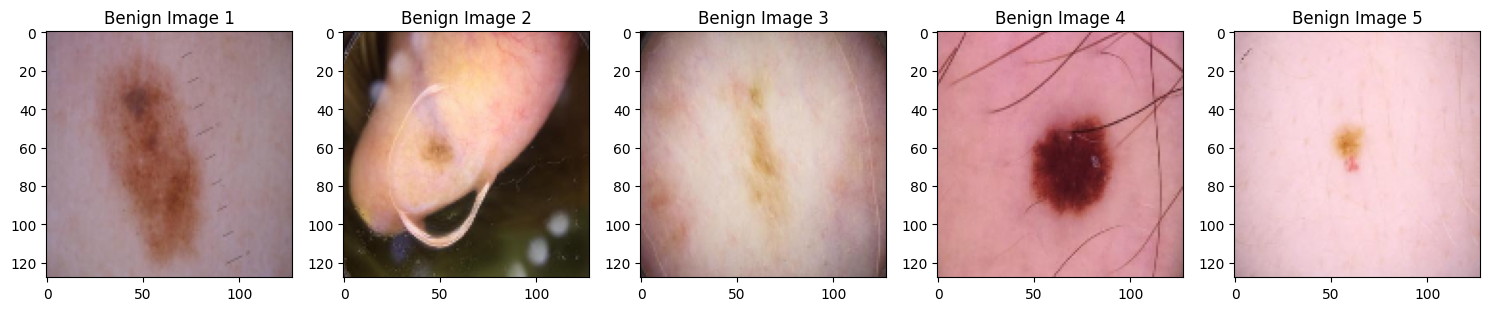

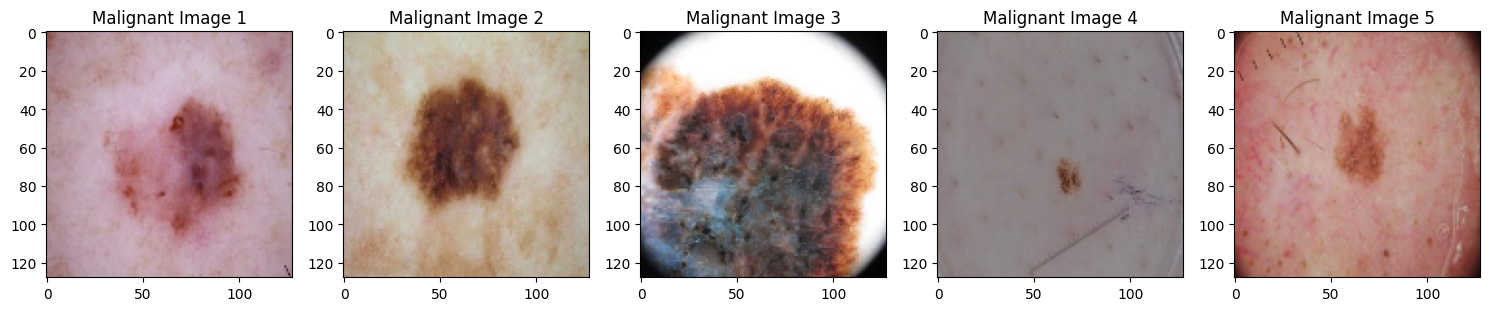

In [ ]:
def display_images(images, title, num_images=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)    #creates grid for displaying images
        plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        plt.title(f"{title} {i + 1}")
    plt.tight_layout()
    plt.show()

display_images(benign_images, "Benign Image", num_images=5)
display_images(malignant_images, "Malignant Image", num_images=5)

**Loading dataset dimensions**

In [ ]:
def load_images_and_dimensions(data_dir):
    images = []
    dimensions = []
    for image_file in os.listdir(data_dir):
        img_path = os.path.join(data_dir, image_file)
        img = load_img(img_path)  # Load image
        img_array = img_to_array(img)  # Convert to array
        images.append(img_array)
        dimensions.append(img_array.shape)  # Store the dimensions
    return images, dimensions

# Load images and dimensions
benign_images, benign_dimensions = load_images_and_dimensions(train_benign_path)
malignant_images, malignant_dimensions = load_images_and_dimensions(train_malignant_path)

**Class count Bargraph**

<ipython-input-7-e073c1f8388f>:5: FutureWarning: Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.  sns.barplot(x=class_labels, y=class_counts, palette='viridis')

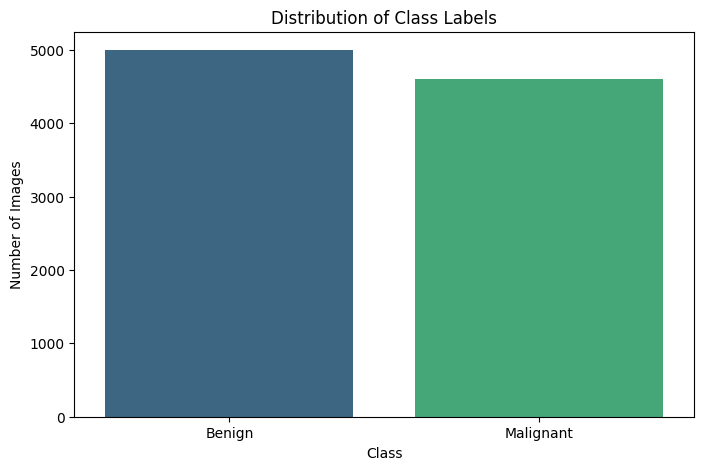

In [ ]:
class_counts = [len(os.listdir(train_benign_path)), len(os.listdir(train_malignant_path))]
class_labels = ['Benign', 'Malignant']

plt.figure(figsize=(8, 5))
sns.barplot(x=class_labels, y=class_counts, palette='viridis')
plt.title('Distribution of Class Labels')
plt.ylabel('Number of Images')
plt.xlabel('Class')
plt.show()

**Histogram for data dimensions**

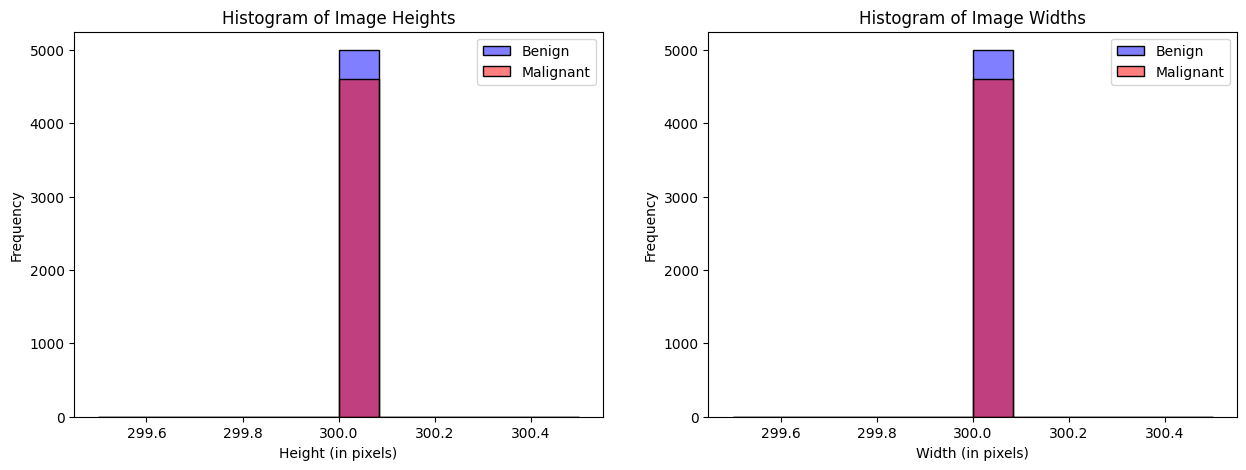

In [ ]:
# Image dimensions histogram
benign_heights = [dim[0] for dim in benign_dimensions]
benign_widths = [dim[1] for dim in benign_dimensions]
malignant_heights = [dim[0] for dim in malignant_dimensions]
malignant_widths = [dim[1] for dim in malignant_dimensions]

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.histplot(benign_heights, bins=12, color='blue', label='Benign', kde=True)
sns.histplot(malignant_heights, bins=12, color='red', label='Malignant', kde=True)
plt.title('Histogram of Image Heights')
plt.xlabel('Height (in pixels)')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(1, 2, 2)
sns.histplot(benign_widths, bins=12, color='blue', label='Benign', kde=True)
sns.histplot(malignant_widths, bins=12, color='red', label='Malignant', kde=True)
plt.title('Histogram of Image Widths')
plt.xlabel('Width (in pixels)')
plt.ylabel('Frequency')
plt.legend()

plt.show()

In [ ]:
pip install imagehash

**Finding Duplicates in dataset**

In [ ]:
import imagehash
import os
import shutil
from PIL import Image

def find_and_move_non_duplicates(image_dir, output_dir):
    if not os.path.isdir(image_dir):
        print(f"Directory does not exist: {image_dir}")
        return

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)  # Create output directory if it doesn't exist

    image_hashes = {}  
    duplicates = []   

    for filename in os.listdir(image_dir):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
            img_path = os.path.join(image_dir, filename)
            try:
                with Image.open(img_path) as img:
                    hash = imagehash.phash(img)  # Calculate perceptual hash
                    if hash in image_hashes:
                        duplicates.append(img_path)  # Store duplicate path
                    else:
                        image_hashes[hash] = img_path  # Store unique hash
                        # Copy unique image to the output directory
                        shutil.copy(img_path, os.path.join(output_dir, filename))
            except Exception as e:
                print(f"Error processing image: {img_path}, error: {e}")

    print(f"Duplicate images found in {image_dir}: {len(duplicates)}")

new_train_benign_path = '/kaggle/input/tezasatyam/INFOSYS/unique_dataset/train/benign'
new_train_malignant_path = '/kaggle/input/tezasatyam/INFOSYS/unique_dataset/train/malignant'
new_test_benign_path = '/kaggle/input/tezasatyam/INFOSYS/unique_dataset/test/benign'
new_test_malignant_path = '/kaggle/input/tezasatyam/INFOSYS/unique_dataset/test/malignant'

# List of dataset paths and corresponding output paths
datasets = [
    (train_benign_path, new_train_benign_path),
    (train_malignant_path, new_train_malignant_path),
    (test_benign_path, new_test_benign_path),
    (test_malignant_path, new_test_malignant_path)
]

# Run duplicate detection and move non-duplicates
for dataset_path, output_path in datasets:
    find_and_move_non_duplicates(dataset_path, output_path)

Duplicate images found in /content/drive/MyDrive/INFOSYS/Original_dataset/train/benign: 8Duplicate images found in /content/drive/MyDrive/INFOSYS/Original_dataset/train/malignant: 18Duplicate images found in /content/drive/MyDrive/INFOSYS/Original_dataset/test/benign: 1Duplicate images found in /content/drive/MyDrive/INFOSYS/Original_dataset/test/malignant: 0

**Dataset after removing duplicates**

In [ ]:
new_benign_images = load_images('/kaggle/input/tezasatyam/INFOSYS/unique_dataset/train/benign')
new_malignant_images = load_images('/kaggle/input/tezasatyam/INFOSYS/unique_dataset/train/malignant')

# Print the number of images loaded
print(f"Total benign images loaded: {len(new_benign_images)}")
print(f"Total malignant images loaded: {len(new_malignant_images)}")

Total benign images loaded: 4992Total malignant images loaded: 4587

**Convert to Grayscale**

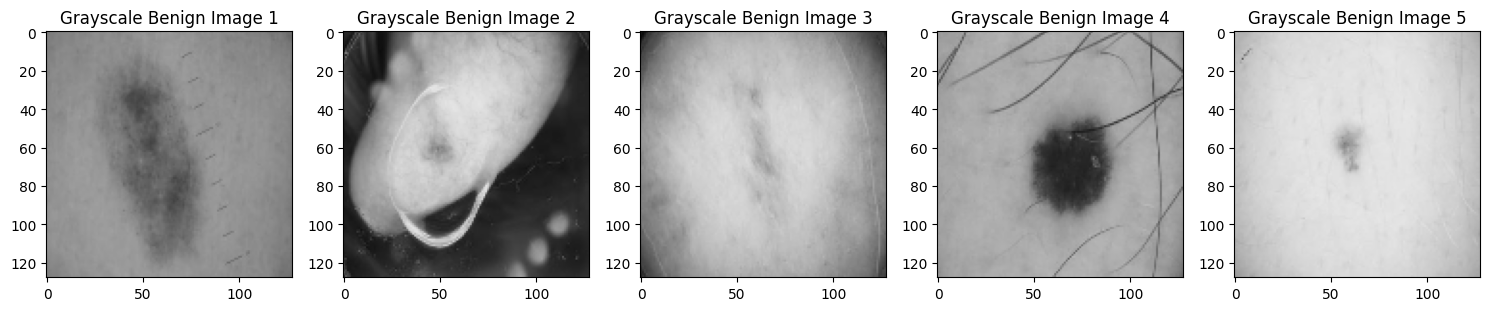

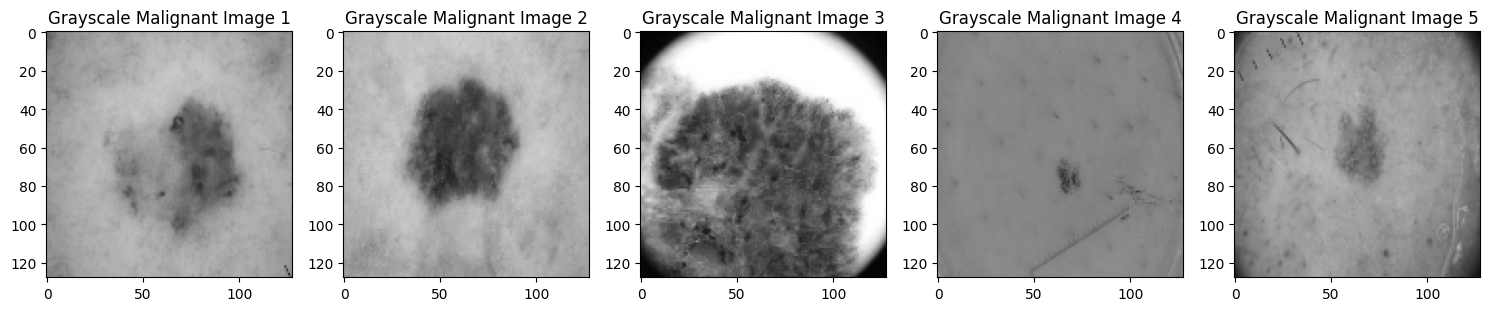

In [ ]:
def convert_to_grayscale(images):
    return [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in images]

benign_images_gray = convert_to_grayscale(new_benign_images)
malignant_images_gray = convert_to_grayscale(new_malignant_images)

display_images(benign_images_gray, "Grayscale Benign Image", num_images=5)
display_images(malignant_images_gray, "Grayscale Malignant Image", num_images=5)

**Comparison between RGB and Grayscale**

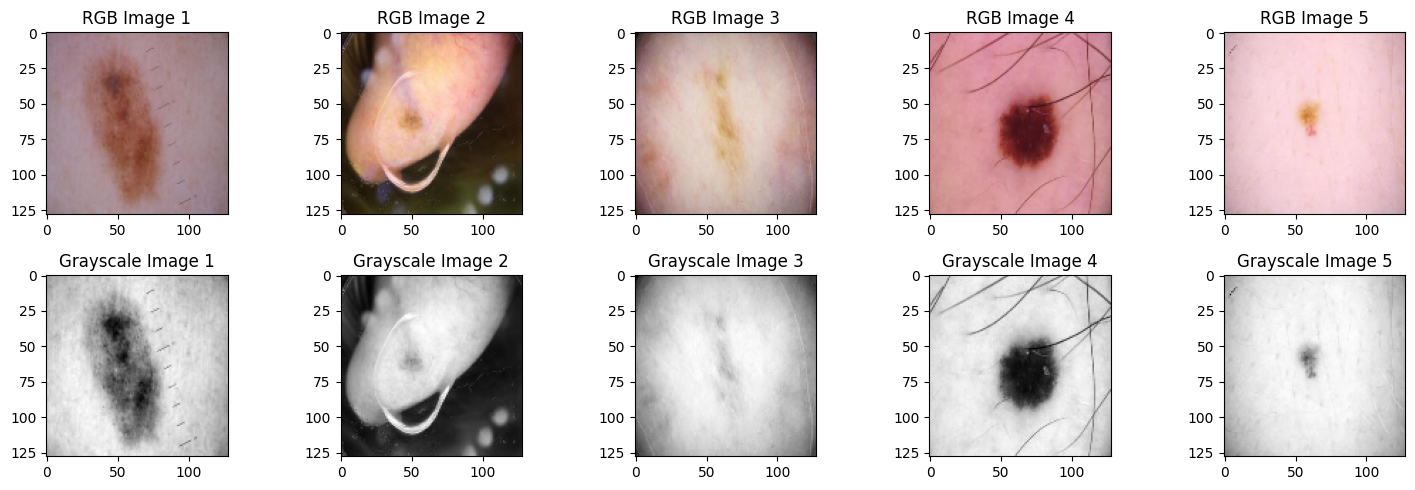

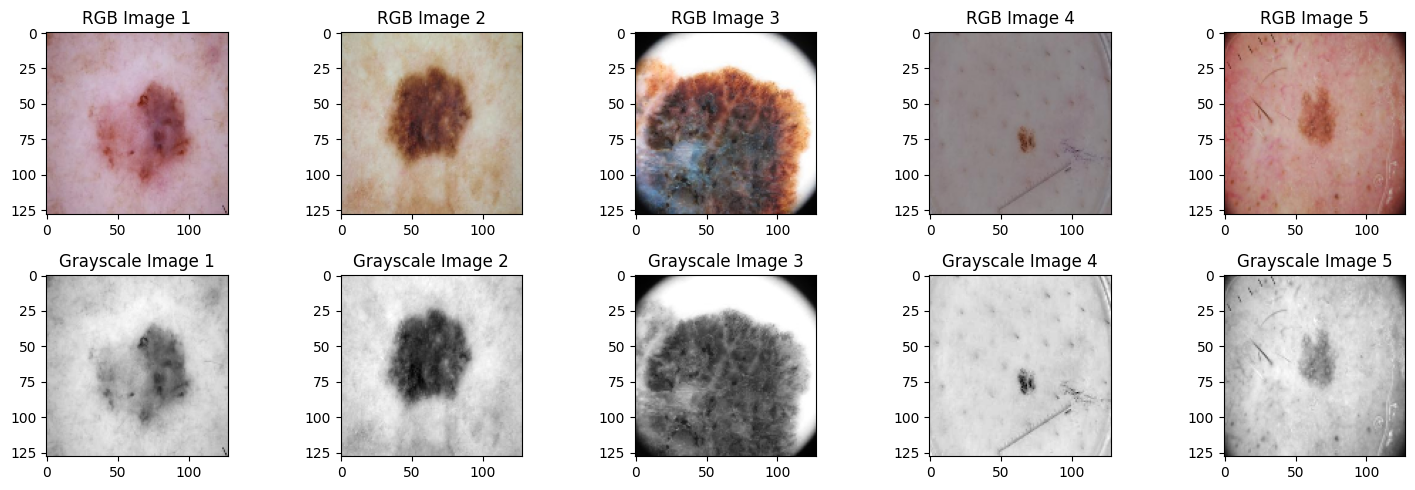

In [ ]:
def display_comparison(rgb_images, grayscale_images, num_images=5):
    plt.figure(figsize=(15, 5))

    for i in range(num_images):
        plt.subplot(2, num_images, i + 1)
        plt.imshow(cv2.cvtColor(rgb_images[i], cv2.COLOR_BGR2RGB))
        plt.title(f"RGB Image {i + 1}")

        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(grayscale_images[i], cmap='gray')
        plt.title(f"Grayscale Image {i + 1}")

    plt.tight_layout()
    plt.show()

display_comparison(new_benign_images, benign_images_gray, num_images=5)

display_comparison(new_malignant_images, malignant_images_gray, num_images=5)

**Normalization of Dataset**

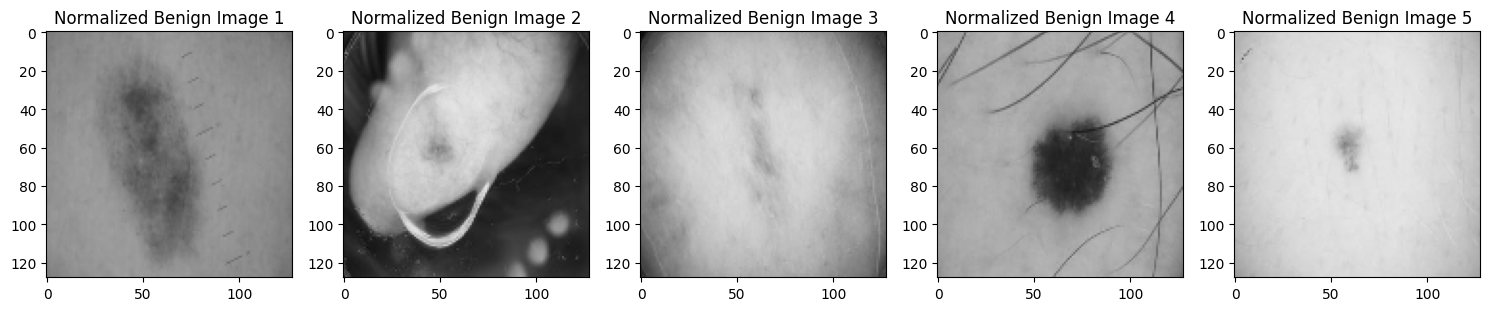

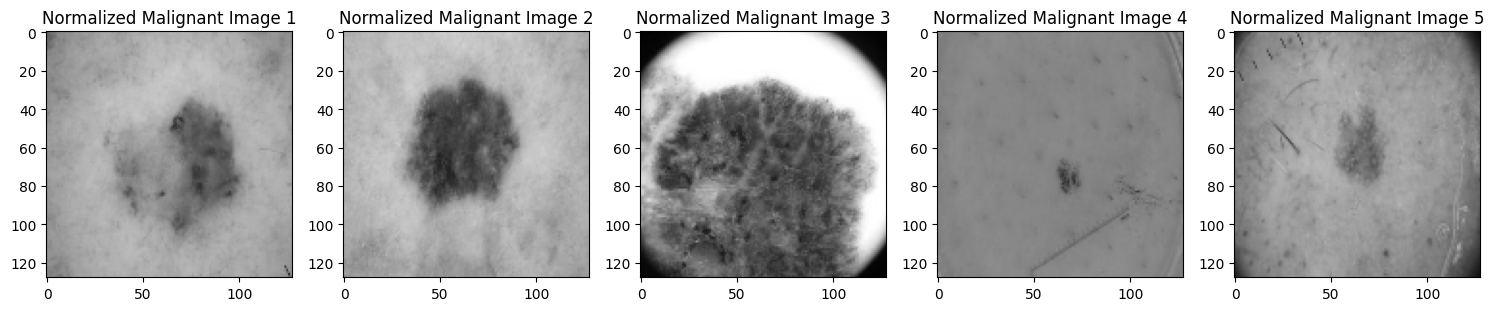

In [ ]:
def normalize_images(images):
    return [img.astype(np.float32) / 255.0 for img in images]

benign_images_normalized = normalize_images(benign_images_gray)
malignant_images_normalized = normalize_images(malignant_images_gray)

display_images(benign_images_normalized, "Normalized Benign Image", num_images=5)
display_images(malignant_images_normalized, "Normalized Malignant Image", num_images=5)

**Display Augmented Images**

Processing 4992 images from Benign directory.


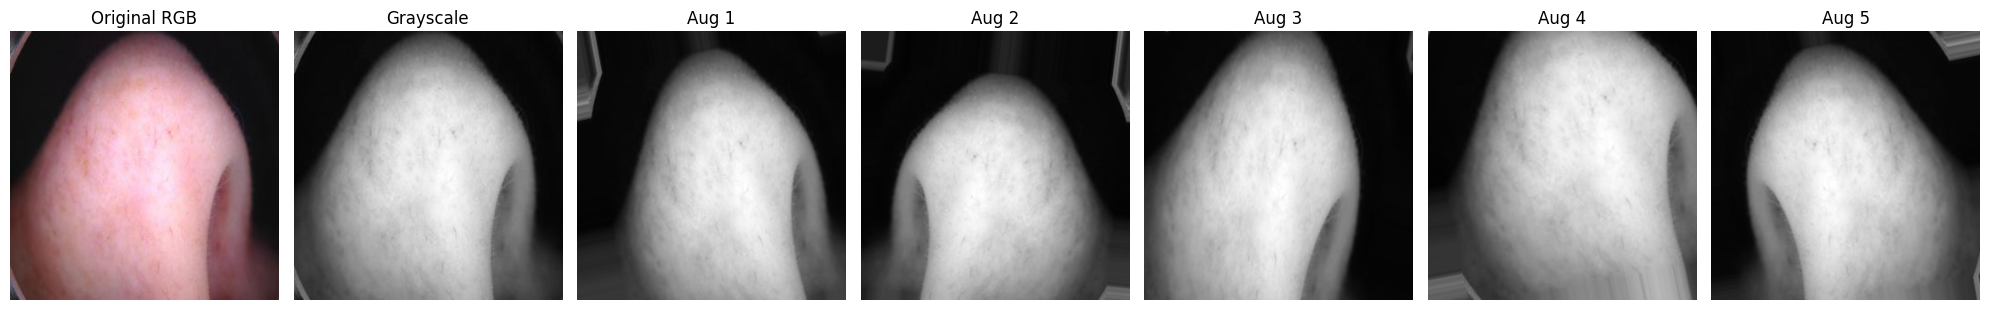

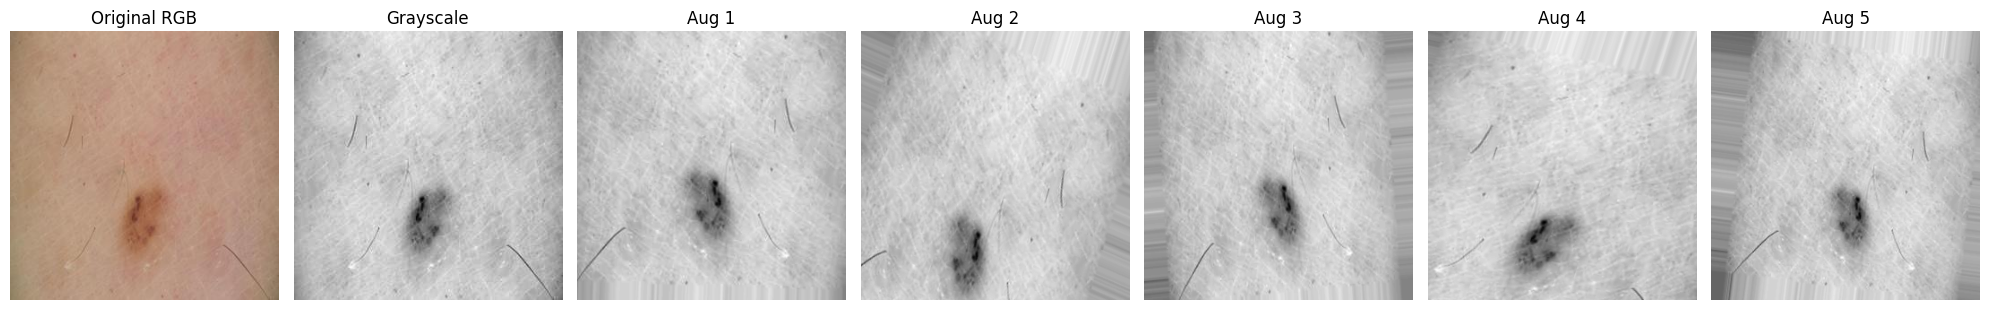

Processing 4587 images from Malignant directory.


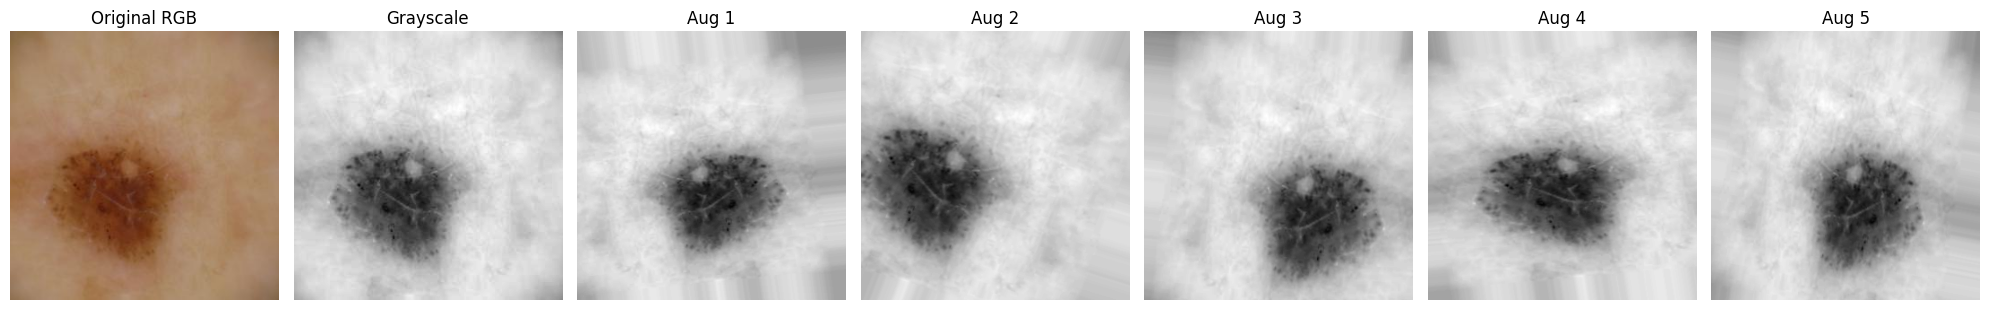

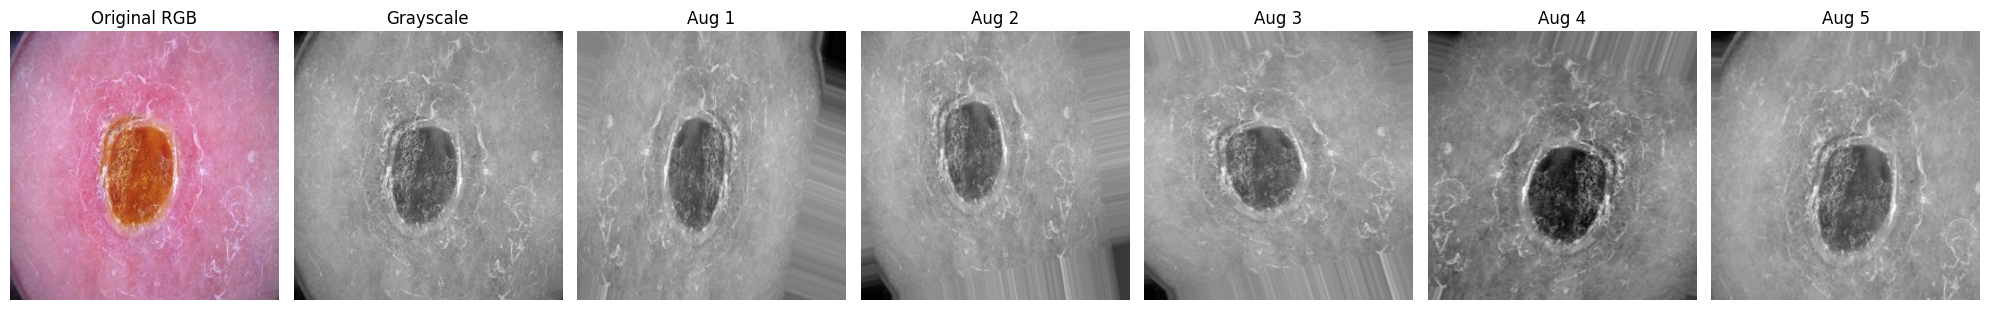

In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

benign_data_dir = '/kaggle/input/tezasatyam/INFOSYS/unique_dataset/train/benign'
malignant_data_dir = '/kaggle/input/tezasatyam/INFOSYS/unique_dataset/train/malignant'

# Define data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

def augment_and_display_images(image_path):
    img_rgb = load_img(image_path)
    img_gray = load_img(image_path, color_mode='grayscale')
    x = img_to_array(img_gray)  # Convert to numpy array for augmentation
    x = np.expand_dims(x, axis=0)  # Reshape to add batch dimension

    # Create a figure to display the images
    fig, axes = plt.subplots(1, 7, figsize=(20, 5))
    
    # Original RGB image
    axes[0].imshow(img_rgb)
    axes[0].axis('off')
    axes[0].set_title("Original RGB")

    # Original grayscale image
    axes[1].imshow(img_gray, cmap='gray')
    axes[1].axis('off')
    axes[1].set_title("Grayscale")

    # Generate and display augmented grayscale images
    aug_iter = datagen.flow(x, batch_size=1)
    for i in range(5):  # Generate 5 augmentations
        aug_image = next(aug_iter)[0].astype('uint8')
        axes[i + 2].imshow(aug_image, cmap='gray')
        axes[i + 2].axis('off')
        axes[i + 2].set_title(f"Aug {i + 1}")

    plt.tight_layout()
    plt.show()

def process_images_in_directory(data_dir, label):
    image_files = os.listdir(data_dir)
    print(f"Processing {len(image_files)} images from {label} directory.")
    for idx, image_file in enumerate(image_files):
        if idx >= 2:  # Display only 2 images per class for Kaggle
            break
        image_path = os.path.join(data_dir, image_file)
        augment_and_display_images(image_path)

# Process and display images
process_images_in_directory(benign_data_dir, "Benign")
process_images_in_directory(malignant_data_dir, "Malignant")


**Counting Augmented Images**

In [ ]:
from PIL import Image 

benign_data_dir = '/kaggle/input/tezasatyam/INFOSYS/unique_dataset/train/benign'   
malignant_data_dir = '/kaggle/input/tezasatyam/INFOSYS/unique_dataset/train/malignant'  
augmented_dir = '/kaggle/input/tezasatyam/INFOSYS/augmented_images'  
os.makedirs(augmented_dir, exist_ok=True)

benign_augmented_dir = os.path.join(augmented_dir, 'benign')
malignant_augmented_dir = os.path.join(augmented_dir, 'malignant')
os.makedirs(benign_augmented_dir, exist_ok=True)
os.makedirs(malignant_augmented_dir, exist_ok=True)

num_augmentations = 5 

def augment_images_from_directory(data_dir, label, save_dir):
    total_augmented = 0
    for image_file in os.listdir(data_dir):
        image_path = os.path.join(data_dir, image_file)
        img = load_img(image_path)
        x = img_to_array(img)       # Convert to numpy array
        x = np.expand_dims(x, axis=0)

        # Generate and save augmentations for each image
        aug_iter = datagen.flow(x, batch_size=1)
        for i in range(num_augmentations):
            aug_image = next(aug_iter)[0].astype('uint8')  # Generate augmented image
            aug_image_path = os.path.join(save_dir, f"{label}_{os.path.splitext(image_file)[0]}_aug_{i+1}.jpg")
            img = Image.fromarray(aug_image)  # Convert array to image
            img.save(aug_image_path)          # Save augmented image
            total_augmented += 1

    return total_augmented

# Augment images for benign and malignant categories
benign_augmented_count = augment_images_from_directory(benign_data_dir, 'benign', benign_augmented_dir)
malignant_augmented_count = augment_images_from_directory(malignant_data_dir, 'malignant', malignant_augmented_dir)

# Count the total number of augmented images
total_augmented_images = benign_augmented_count + malignant_augmented_count
print(f"Total number of augmented images for benign: {benign_augmented_count}")
print(f"Total number of augmented images for malignant: {malignant_augmented_count}")
print(f"Total number of augmented images: {total_augmented_images}")

Total number of augmented images for benign: 24960Total number of augmented images for malignant: 22935Total number of augmented images: 47895

Model 1 :- **Unique RGB Model**

In [2]:
train_dir = "/kaggle/input/tezasatyam/INFOSYS/unique_dataset/train"
test_dir = "/kaggle/input/tezasatyam/INFOSYS/unique_dataset/test"

train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(150, 150), batch_size=32, class_mode='binary', subset='training'
)
val_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(150, 150), batch_size=32, class_mode='binary', subset='validation'
)
test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=(150, 150), batch_size=32, class_mode='binary'
)

# Build the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator, 
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator, 
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=10
)

# Evaluate the model on the test set
test_generator.reset()  # Reset the test generator
loss, accuracy = model.evaluate(test_generator)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

Found 7664 images belonging to 2 classes.
Found 1915 images belonging to 2 classes.
Found 999 images belonging to 2 classes.


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


239/239 ━━━━━━━━━━━━━━━━━━━━ 191s 783ms/step - accuracy: 0.7300 - loss: 0.6912 - val_accuracy: 0.8618 - val_loss: 0.3150
Epoch 2/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 782us/step - accuracy: 0.8750 - loss: 0.2644 - val_accuracy: 0.7037 - val_loss: 0.5138
Epoch 3/10


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


239/239 ━━━━━━━━━━━━━━━━━━━━ 173s 720ms/step - accuracy: 0.8558 - loss: 0.3368 - val_accuracy: 0.8628 - val_loss: 0.3057
Epoch 4/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 731us/step - accuracy: 0.9688 - loss: 0.1178 - val_accuracy: 0.9630 - val_loss: 0.2037
Epoch 5/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 172s 719ms/step - accuracy: 0.8767 - loss: 0.2885 - val_accuracy: 0.8845 - val_loss: 0.2751
Epoch 6/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 754us/step - accuracy: 0.9062 - loss: 0.3087 - val_accuracy: 0.8889 - val_loss: 0.2749
Epoch 7/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 173s 720ms/step - accuracy: 0.8921 - loss: 0.2573 - val_accuracy: 0.8888 - val_loss: 0.2650
Epoch 8/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 712us/step - accuracy: 0.9688 - loss: 0.1605 - val_accuracy: 0.8889 - val_loss: 0.2978
Epoch 9/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 171s 708ms/step - accuracy: 0.8945 - loss: 0.2489 - val_accuracy: 0.8845 - val_loss: 0.2704
Epoch 10/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 636us/step - accuracy: 0.8438 - loss: 0.4250 - va

In [5]:
from sklearn.metrics import f1_score
import numpy as np

# Get true labels and predictions from the test_generator
test_generator.reset()  # Reset the test generator
y_true = test_generator.classes  # True labels
y_pred = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)  # Predicted probabilities
y_pred = (y_pred > 0.5).astype(int).flatten()  # Convert probabilities to binary predictions

# Calculate F1-scores for each class
f1_scores = f1_score(y_true, y_pred, average=None)
class_indices = test_generator.class_indices
class_names = list(class_indices.keys())

# Print F1-score for each class
for class_name, f1 in zip(class_names, f1_scores):
    print(f"F1-score for {class_name}: {f1}")
    
# Save the model
model.save("RGB_cnn_model.h5")
print("Model saved as RGB_cnn_model.h5")

32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 202ms/step
F1-score for benign: 0.5091610414657667
F1-score for malignant: 0.47034339229968786
Model saved as RGB_cnn_model.h5


**Convert Unique RGB into Grayscale and store**

In [ ]:
train_rgb_malignant = "/kaggle/input/tezasatyam/INFOSYS/unique_dataset/train/malignant"
train_rgb_benign = "/kaggle/input/tezasatyam/INFOSYS/unique_dataset/train/benign"
train_grayscale_malignant = "/kaggle/input/tezasatyam/INFOSYS/grayscale_unique/train/malignant"
train_grayscale_benign = "/kaggle/input/tezasatyam/INFOSYS/grayscale_unique/train/benign"

test_rgb_malignant = "/kaggle/input/tezasatyam/INFOSYS/unique_dataset/test/malignant"
test_rgb_benign = "/kaggle/input/tezasatyam/INFOSYS/unique_dataset/test/benign"
test_grayscale_malignant = "/kaggle/input/tezasatyam/INFOSYS/grayscale_unique/test/malignant"
test_grayscale_benign = "/kaggle/input/tezasatyam/INFOSYS/grayscale_unique/test/benign"

os.makedirs(train_grayscale_malignant, exist_ok=True)
os.makedirs(train_grayscale_benign, exist_ok=True)
os.makedirs(test_grayscale_malignant, exist_ok=True)
os.makedirs(test_grayscale_benign, exist_ok=True)

def convert_to_grayscale(source_dir, dest_dir):
    for file_name in os.listdir(source_dir):
        source_file = os.path.join(source_dir, file_name)

        if os.path.isfile(source_file) and file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            img = cv2.imread(source_file)
            # Convert to grayscale
            gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            dest_file = os.path.join(dest_dir, file_name)
            cv2.imwrite(dest_file, gray_img)

convert_to_grayscale(train_rgb_malignant, train_grayscale_malignant)
convert_to_grayscale(train_rgb_benign, train_grayscale_benign)
convert_to_grayscale(test_rgb_malignant, test_grayscale_malignant)
convert_to_grayscale(test_rgb_benign, test_grayscale_benign)

Model 2 :- **Unique Grayscale Model**

In [6]:
train_gray_dir = "/kaggle/input/tezasatyam/INFOSYS/grayscale_unique/train"
test_gray_dir = "/kaggle/input/tezasatyam/INFOSYS/grayscale_unique/test"

train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_gray_dir, target_size=(150, 150), batch_size=32, class_mode='binary', subset='training'
)
val_generator = train_datagen.flow_from_directory(
    train_gray_dir, target_size=(150, 150), batch_size=32, class_mode='binary', subset='validation'
)
test_generator = test_datagen.flow_from_directory(
    test_gray_dir, target_size=(150, 150), batch_size=32, class_mode='binary'
)

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(
    train_generator, steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator, validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=10
)

loss, accuracy = model.evaluate(test_generator)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

Found 7664 images belonging to 2 classes.
Found 1915 images belonging to 2 classes.
Found 999 images belonging to 2 classes.


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


239/239 ━━━━━━━━━━━━━━━━━━━━ 189s 773ms/step - accuracy: 0.6620 - loss: 0.6984 - val_accuracy: 0.7998 - val_loss: 0.3904
Epoch 2/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 761us/step - accuracy: 0.9062 - loss: 0.3067 - val_accuracy: 0.7407 - val_loss: 0.4561
Epoch 3/10


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


239/239 ━━━━━━━━━━━━━━━━━━━━ 178s 744ms/step - accuracy: 0.7840 - loss: 0.4235 - val_accuracy: 0.8167 - val_loss: 0.3626
Epoch 4/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 729us/step - accuracy: 0.8125 - loss: 0.3375 - val_accuracy: 0.7407 - val_loss: 0.3775
Epoch 5/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 178s 744ms/step - accuracy: 0.8112 - loss: 0.3855 - val_accuracy: 0.8242 - val_loss: 0.3461
Epoch 6/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 735us/step - accuracy: 0.8750 - loss: 0.2546 - val_accuracy: 0.7778 - val_loss: 0.4211
Epoch 7/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 177s 736ms/step - accuracy: 0.8359 - loss: 0.3476 - val_accuracy: 0.8337 - val_loss: 0.3577
Epoch 8/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 754us/step - accuracy: 0.8125 - loss: 0.3712 - val_accuracy: 0.9630 - val_loss: 0.2020
Epoch 9/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 174s 729ms/step - accuracy: 0.8476 - loss: 0.3321 - val_accuracy: 0.8289 - val_loss: 0.3505
Epoch 10/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 724us/step - accuracy: 0.8125 - loss: 0.3297 - va

In [7]:
y_true = test_generator.classes  
test_generator.reset()  
y_pred = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
y_pred = (y_pred > 0.5).astype(int).flatten()  

f1_scores = f1_score(y_true, y_pred, average=None)  # Calculate F1-score for each class
class_indices = test_generator.class_indices  
class_names = list(class_indices.keys())  

# Display F1-scores for each class
for class_name, f1 in zip(class_names, f1_scores):
    print(f"F1-score for {class_name}: {f1}")

# 6. Save the model
model.save("Grayscale_cnn_model.h5")
print("Model saved as Grayscale_cnn_model.h5")

32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 202ms/step
F1-score for benign: 0.49292929292929294
F1-score for malignant: 0.5019841269841271
Model saved as Grayscale_cnn_model.h5


**Convert Augmented RGB into Grayscale and store**

In [ ]:
rgb_benign_augmented_images = "/kaggle/input/tezasatyam/INFOSYS/augmented_images/benign"
rgb_malignant_augmented_images = "/kaggle/input/tezasatyam/INFOSYS/augmented_images/malignant"

grayscale_benign_augmented_images = "/kaggle/input/tezasatyam/INFOSYS/gray_aug_images/benign"
grayscale_malignant_augmented_images = "/kaggle/input/tezasatyam/INFOSYS/gray_aug_images/malignant"

os.makedirs(grayscale_benign_augmented_images, exist_ok=True)
os.makedirs(grayscale_malignant_augmented_images, exist_ok=True)

def convert_to_grayscale(source_dir, dest_dir):
    for file_name in os.listdir(source_dir):
        source_file = os.path.join(source_dir, file_name)

        if os.path.isfile(source_file) and file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            img = cv2.imread(source_file)
            # Convert to grayscale
            gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            dest_file = os.path.join(dest_dir, file_name)
            cv2.imwrite(dest_file, gray_img)

convert_to_grayscale(rgb_benign_augmented_images, grayscale_benign_augmented_images)
convert_to_grayscale(rgb_malignant_augmented_images, grayscale_malignant_augmented_images)

Model 3 :- **Grayscale Augmentation Model**

In [3]:
gray_aug_img="/kaggle/input/tezasatyam/INFOSYS/gray_aug_images"

augmented_train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # Split for validation data
)

augmented_gray_train_generator = augmented_train_datagen.flow_from_directory(
    gray_aug_img,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='training'
)
augmented_gray_val_generator = augmented_train_datagen.flow_from_directory(
    gray_aug_img,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

augmented_gray_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

augmented_gray_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

augmented_gray_history = augmented_gray_model.fit(
    augmented_gray_train_generator,
    steps_per_epoch=augmented_gray_train_generator.samples // augmented_gray_train_generator.batch_size,
    validation_data=augmented_gray_val_generator,
    validation_steps=augmented_gray_val_generator.samples // augmented_gray_val_generator.batch_size,
    epochs=10
)

augmented_loss, augmented_accuracy = augmented_gray_model.evaluate(augmented_gray_val_generator)
print(f"Augmented Model Test Loss: {augmented_loss}")
print(f"Augmented Model Test Accuracy: {augmented_accuracy}")

Found 38316 images belonging to 2 classes.
Found 9579 images belonging to 2 classes.


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1197/1197 ━━━━━━━━━━━━━━━━━━━━ 864s 719ms/step - accuracy: 0.7414 - loss: 0.5718 - val_accuracy: 0.8039 - val_loss: 0.4086
Epoch 2/10
1197/1197 ━━━━━━━━━━━━━━━━━━━━ 1s 58us/step - accuracy: 0.8125 - loss: 0.3793 - val_accuracy: 0.6364 - val_loss: 0.6232
Epoch 3/10


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1197/1197 ━━━━━━━━━━━━━━━━━━━━ 843s 704ms/step - accuracy: 0.8354 - loss: 0.3547 - val_accuracy: 0.8500 - val_loss: 0.3317
Epoch 4/10
1197/1197 ━━━━━━━━━━━━━━━━━━━━ 1s 52us/step - accuracy: 0.7812 - loss: 0.4813 - val_accuracy: 1.0000 - val_loss: 0.2317
Epoch 5/10
1197/1197 ━━━━━━━━━━━━━━━━━━━━ 830s 693ms/step - accuracy: 0.8503 - loss: 0.3306 - val_accuracy: 0.8410 - val_loss: 0.3340
Epoch 6/10
1197/1197 ━━━━━━━━━━━━━━━━━━━━ 1s 58us/step - accuracy: 0.8750 - loss: 0.2672 - val_accuracy: 0.8182 - val_loss: 0.3451
Epoch 7/10
1197/1197 ━━━━━━━━━━━━━━━━━━━━ 822s 687ms/step - accuracy: 0.8630 - loss: 0.3029 - val_accuracy: 0.8820 - val_loss: 0.2838
Epoch 8/10
1197/1197 ━━━━━━━━━━━━━━━━━━━━ 1s 53us/step - accuracy: 0.8438 - loss: 0.2910 - val_accuracy: 0.9091 - val_loss: 0.3538
Epoch 9/10
1197/1197 ━━━━━━━━━━━━━━━━━━━━ 846s 706ms/step - accuracy: 0.8795 - loss: 0.2768 - val_accuracy: 0.8823 - val_loss: 0.2785
Epoch 10/10
1197/1197 ━━━━━━━━━━━━━━━━━━━━ 1s 58us/step - accuracy: 0.9062 - loss:

In [4]:
from sklearn.metrics import f1_score  

y_true = augmented_gray_val_generator.classes  
augmented_gray_val_generator.reset()  

# Get predictions from the model
y_pred = augmented_gray_model.predict(
    augmented_gray_val_generator,
    steps=augmented_gray_val_generator.samples // augmented_gray_val_generator.batch_size + 1
)
y_pred = (y_pred > 0.5).astype(int).flatten()  

# Calculate F1-score for each class
f1_scores = f1_score(y_true, y_pred, average=None)

# Get class-to-index mapping
class_indices = augmented_gray_val_generator.class_indices  
class_names = list(class_indices.keys())  # Class names

# Display F1-scores for each class
for class_name, f1 in zip(class_names, f1_scores):
    print(f"F1-score for {class_name}: {f1}")

# Save the Model
augmented_gray_model.save("Augmented_Grayscale_Model.h5")
print("Model saved as Augmented_Grayscale_Model.h5")


300/300 ━━━━━━━━━━━━━━━━━━━━ 59s 196ms/step
F1-score for benign: 0.5349496529475022
F1-score for malignant: 0.4672415724045246
Model saved as Augmented_Grayscale_Model.h5


Model 4:- **RGB Augmentation Model**

In [5]:
aug_dir="/kaggle/input/tezasatyam/INFOSYS/augmented_images"

augmented_train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

augmented_train_generator = augmented_train_datagen.flow_from_directory(
    aug_dir,
    target_size=(150, 150),
    batch_size=64,
    class_mode='binary',
    subset='training'
)
augmented_val_generator = augmented_train_datagen.flow_from_directory(
    aug_dir,
    target_size=(150, 150),
    batch_size=64,
    class_mode='binary',
    subset='validation'
)

augmented_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

augmented_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

augmented_history = augmented_model.fit(
    augmented_train_generator,
    steps_per_epoch=augmented_train_generator.samples // augmented_train_generator.batch_size,
    validation_data=augmented_val_generator,
    validation_steps=augmented_val_generator.samples // augmented_val_generator.batch_size,
    epochs=10
)

augmented_loss, augmented_accuracy = augmented_model.evaluate(augmented_val_generator)
print(f"Augmented Model Test Loss: {augmented_loss}")
print(f"Augmented Model Test Accuracy: {augmented_accuracy}")

Found 38316 images belonging to 2 classes.
Found 9579 images belonging to 2 classes.


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


598/598 ━━━━━━━━━━━━━━━━━━━━ 804s 1s/step - accuracy: 0.8099 - loss: 0.4479 - val_accuracy: 0.8726 - val_loss: 0.3201
Epoch 2/10
  1/598 ━━━━━━━━━━━━━━━━━━━━ 11:16 1s/step - accuracy: 0.9062 - loss: 0.2458

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


598/598 ━━━━━━━━━━━━━━━━━━━━ 1s 407us/step - accuracy: 0.9062 - loss: 0.2458 - val_accuracy: 0.9302 - val_loss: 0.2416
Epoch 3/10
598/598 ━━━━━━━━━━━━━━━━━━━━ 754s 1s/step - accuracy: 0.8803 - loss: 0.2834 - val_accuracy: 0.8793 - val_loss: 0.2947
Epoch 4/10
598/598 ━━━━━━━━━━━━━━━━━━━━ 1s 379us/step - accuracy: 0.8750 - loss: 0.2811 - val_accuracy: 0.9302 - val_loss: 0.2272
Epoch 5/10
598/598 ━━━━━━━━━━━━━━━━━━━━ 787s 1s/step - accuracy: 0.8915 - loss: 0.2579 - val_accuracy: 0.8929 - val_loss: 0.2636
Epoch 6/10
598/598 ━━━━━━━━━━━━━━━━━━━━ 27s 44ms/step - accuracy: 0.8750 - loss: 0.2953 - val_accuracy: 0.8605 - val_loss: 0.2717
Epoch 7/10
598/598 ━━━━━━━━━━━━━━━━━━━━ 739s 1s/step - accuracy: 0.8942 - loss: 0.2517 - val_accuracy: 0.8848 - val_loss: 0.2841
Epoch 8/10
598/598 ━━━━━━━━━━━━━━━━━━━━ 1s 384us/step - accuracy: 0.8906 - loss: 0.2947 - val_accuracy: 0.8372 - val_loss: 0.3601
Epoch 9/10
598/598 ━━━━━━━━━━━━━━━━━━━━ 739s 1s/step - accuracy: 0.9008 - loss: 0.2352 - val_accuracy: 0

In [6]:
y_true = augmented_val_generator.classes  
augmented_val_generator.reset()  
y_pred = augmented_model.predict(
    augmented_val_generator,
    steps=augmented_val_generator.samples // augmented_val_generator.batch_size + 1
)
y_pred = (y_pred > 0.5).astype(int).flatten()  

f1_scores = f1_score(y_true, y_pred, average=None)  
class_indices = augmented_val_generator.class_indices  
class_names = list(class_indices.keys())  

# Display F1-scores for each class
for class_name, f1 in zip(class_names, f1_scores):
    print(f"F1-score for {class_name}: {f1}")

# 6. Save the Model
augmented_model.save("Augmented_Model_Using_Augmented_Images.h5")
print("Model saved as Augmented_Model_Using_Augmented_Images.h5")

150/150 ━━━━━━━━━━━━━━━━━━━━ 54s 360ms/step
F1-score for benign: 0.561171204774338
F1-score for malignant: 0.44202039364477114
Model saved as Augmented_Model_Using_Augmented_Images.h5


Model 5:- **VGG16 Model**

In [7]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

dir = '/kaggle/input/tezasatyam/INFOSYS/grayscale_unique/train'


# Data Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Load Data
train_generator = train_datagen.flow_from_directory(
    dir,
    target_size=(150, 150),  
    batch_size=32,
    class_mode='binary',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

weights_path = '/kaggle/input/tezassss/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_model = VGG16(weights=weights_path, include_top=False, input_shape=(150, 150, 3))

for layer in base_model.layers:
    layer.trainable = False

# Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=10
)

# Evaluate the model
loss, accuracy = model.evaluate(val_generator)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

Found 7664 images belonging to 2 classes.
Found 1915 images belonging to 2 classes.
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


239/239 ━━━━━━━━━━━━━━━━━━━━ 1029s 4s/step - accuracy: 0.7354 - loss: 0.5114 - val_accuracy: 0.8591 - val_loss: 0.3447
Epoch 2/10
  1/239 ━━━━━━━━━━━━━━━━━━━━ 13:24 3s/step - accuracy: 0.8125 - loss: 0.2922

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


239/239 ━━━━━━━━━━━━━━━━━━━━ 58s 230ms/step - accuracy: 0.8125 - loss: 0.2922 - val_accuracy: 0.9259 - val_loss: 0.2529
Epoch 3/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 1028s 4s/step - accuracy: 0.8286 - loss: 0.3838 - val_accuracy: 0.8755 - val_loss: 0.3133
Epoch 4/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.8750 - loss: 0.2820 - val_accuracy: 0.8519 - val_loss: 0.3068
Epoch 5/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 1023s 4s/step - accuracy: 0.8578 - loss: 0.3343 - val_accuracy: 0.8782 - val_loss: 0.3025
Epoch 6/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 59s 233ms/step - accuracy: 0.9688 - loss: 0.2092 - val_accuracy: 0.8148 - val_loss: 0.3438
Epoch 7/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 1026s 4s/step - accuracy: 0.8586 - loss: 0.3227 - val_accuracy: 0.8665 - val_loss: 0.3057
Epoch 8/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.8438 - loss: 0.2668 - val_accuracy: 0.9630 - val_loss: 0.2182
Epoch 9/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 1025s 4s/step - accuracy: 0.8658 - loss: 0.3009 - val_accurac

In [8]:
y_true = val_generator.classes  
val_generator.reset()  
y_pred = model.predict(
    val_generator,
    steps=val_generator.samples // val_generator.batch_size + 1
)
y_pred = (y_pred > 0.5).astype(int).flatten() 

f1_scores = f1_score(y_true, y_pred, average=None)  
class_indices = val_generator.class_indices  
class_names = list(class_indices.keys())  

# Display F1-scores for each class
for class_name, f1 in zip(class_names, f1_scores):
    print(f"F1-score for {class_name}: {f1}")

# 9. Save the Model
model.save("VGG16_Transfer_Learning_Model.h5")
print("Model saved as VGG16_Transfer_Learning_Model.h5")

60/60 ━━━━━━━━━━━━━━━━━━━━ 207s 3s/step
F1-score for benign: 0.5500246426811237
F1-score for malignant: 0.49305941143808996
Model saved as VGG16_Transfer_Learning_Model.h5


Model 6:- **VGG19 Model**

In [10]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

train_dir = '/kaggle/input/tezasatyam/INFOSYS/grayscale_unique/train'
test_dir = '/kaggle/input/tezasatyam/INFOSYS/grayscale_unique/test'

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    validation_split=0.2 
)
test_datagen = ImageDataGenerator(
    rescale=1.0 / 255 
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),  
    batch_size=16,  
    class_mode='binary',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=16,
    class_mode='binary',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=16,
    class_mode='binary'
)


weights_path = '/kaggle/input/satyammm/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'

base_model = VGG19(weights=weights_path, include_top=False, input_shape=(150, 150, 3))

for layer in base_model.layers:
    layer.trainable = False

# Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=10
)

# Evaluate the model on test data
loss, accuracy = model.evaluate(test_generator)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")


Found 7664 images belonging to 2 classes.
Found 1915 images belonging to 2 classes.
Found 999 images belonging to 2 classes.
Epoch 1/10
479/479 ━━━━━━━━━━━━━━━━━━━━ 1257s 3s/step - accuracy: 0.7423 - loss: 0.5110 - val_accuracy: 0.8550 - val_loss: 0.3580
Epoch 2/10


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


479/479 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8182 - val_loss: 0.6112
Epoch 3/10
479/479 ━━━━━━━━━━━━━━━━━━━━ 1255s 3s/step - accuracy: 0.8423 - loss: 0.3672 - val_accuracy: 0.8566 - val_loss: 0.3385
Epoch 4/10
479/479 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8182 - val_loss: 0.5123
Epoch 5/10
479/479 ━━━━━━━━━━━━━━━━━━━━ 1256s 3s/step - accuracy: 0.8524 - loss: 0.3454 - val_accuracy: 0.8582 - val_loss: 0.3289
Epoch 6/10
479/479 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9091 - val_loss: 0.2531
Epoch 7/10
479/479 ━━━━━━━━━━━━━━━━━━━━ 1282s 3s/step - accuracy: 0.8599 - loss: 0.3255 - val_accuracy: 0.8650 - val_loss: 0.3252
Epoch 8/10
479/479 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8182 - val_loss: 0.2914
Epoch 9/10
479/479 ━━━━━━━━━━━━━━━━━━━━ 1256s 3s/step - accuracy: 0.8692 - lo

In [11]:
# Predictions for test data
y_true = test_generator.classes 
y_pred_probs = model.predict(test_generator) 
y_pred = (y_pred_probs > 0.5).astype(int).flatten()  

# F1 Score Calculation
f1_scores = f1_score(y_true, y_pred, average=None)
class_indices = test_generator.class_indices
class_names = list(class_indices.keys())

# Print F1-scores for each class
for class_name, f1 in zip(class_names, f1_scores):
    print(f"F1-score for {class_name}: {f1}")

# Save the trained model
model.save("VGG19_Skin_Cancer_Model.h5")
print("Model saved as VGG19_Skin_Cancer_Model.h5")

63/63 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step
F1-score for benign: 0.5039999999999999
F1-score for malignant: 0.5030060120240482
Model saved as VGG19_Skin_Cancer_Model.h5


**Accuracy Comparison Table**

In [5]:
data = {
    "S.No": [1, 2, 3, 4, 5, 6],
    "Model": [
        "Unique RGB model",
        "Unique Grayscale model",
        "Grayscale Augmented model",
        "RGB Augmented model",
        "VGG16 model",
        "VGG19 model"
    ],
    "Accuracy (%)": [89.68, 86.18, 88.25, 87.57, 87.72, 86.18]
}

# Creating a DataFrame
df = pd.DataFrame(data)

# Rounding the numerical columns
df["Accuracy (%)"] = df["Accuracy (%)"].round(2)


# Adjust display settings for better alignment
pd.set_option("display.colheader_justify", "center")  
pd.set_option("display.width", 1000)  

# Displaying the DataFrame
print("Model Accuracy Comparison")
print(df)


Model Accuracy Comparison
   S.No           Model             Accuracy (%)
0    1            Unique RGB model      89.68   
1    2      Unique Grayscale model      86.18   
2    3   Grayscale Augmented model      88.25   
3    4         RGB Augmented model      87.57   
4    5                 VGG16 model      87.72   
5    6                 VGG19 model      86.18   


I have found that my **Grayscale augmented model** has the highest **accuracy(88.25)**, so I want to use this model.

**Classification Report**

In [6]:
from sklearn.metrics import classification_report

# Generate true labels and predictions
y_true = augmented_gray_val_generator.classes  # True labels
augmented_gray_val_generator.reset()  # Reset the generator
y_pred_probs = augmented_gray_model.predict(
    augmented_gray_val_generator,
    steps=augmented_gray_val_generator.samples // augmented_gray_val_generator.batch_size + 1
)
y_pred = (y_pred_probs > 0.5).astype(int).flatten() 

# Create a classification report
class_names = list(augmented_gray_val_generator.class_indices.keys())  
report = classification_report(y_true, y_pred, target_names=class_names)

print("Classification Report:")
print(report)


300/300 ━━━━━━━━━━━━━━━━━━━━ 58s 192ms/step
Classification Report:
              precision    recall  f1-score   support

      benign       0.52      0.54      0.53      4992
   malignant       0.48      0.45      0.46      4587

    accuracy                           0.50      9579
   macro avg       0.50      0.50      0.50      9579
weighted avg       0.50      0.50      0.50      9579



**Confusion Matrix**

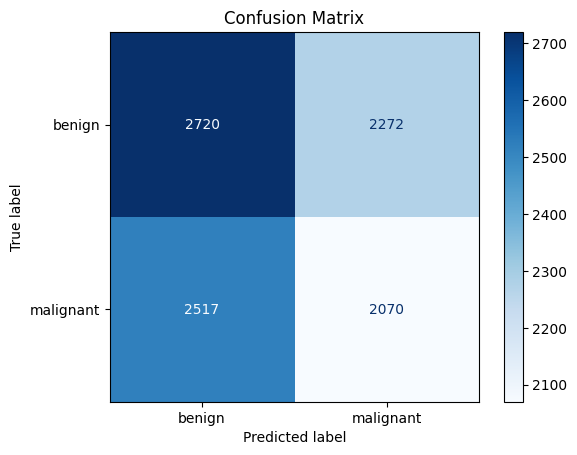

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)
class_names = list(augmented_gray_val_generator.class_indices.keys())  

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


**CONCLUSION**

Our skin cancer detection model helps identify skin lesions as either benign or malignant to support early and accurate diagnosis. 